In [1]:
import seaborn as sns
import pandas as pd
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

In [2]:
uniqueness = set()

In [3]:
import gzip

def get_consensus_group_size_per_read(fastq_file: str, id_to_umi: dict[int, str]) -> list[int]:
    """Reads a FASTQ file chunk and returns a list of reads."""
    umi_to_group_size_per_read = defaultdict(int)
    num_reads = 0
    with gzip.open(fastq_file, 'rb') as f:
        while header := f.readline().strip().decode("utf-8"):  # read header string
            if not header:
                break
            _ = f.readline()
            _ = f.readline()
            _ = f.readline()
            
            group_ids = header.split('\t')[1].split(';')[:-1]
            consensus_group_size = len(group_ids)  # @0  145607;265853;563279;
            # print(header, group_ids, consensus_group_size)
            
            umi = Counter([id_to_umi[int(x)] for x in group_ids]).most_common(1)[0][0]
            umi_to_group_size_per_read[umi] += consensus_group_size
            num_reads += 1

    print(num_reads)    
    return umi_to_group_size_per_read
    


In [4]:
sequences = []

In [5]:
def get_read_to_umi_mapping(fastq_file: str, umi_len: int = 12) -> dict[str, int]:
    umi_to_count = defaultdict(int)
    id_to_umi = {}
    read_id = 0
    with gzip.open(fastq_file) as f:
        while header := f.readline().strip().decode("utf-8"):  # read header string
            if not header:
                break
            sequence = f.readline()
            sequences.append(sequence)
            _ = f.readline()
            _ = f.readline()
            
            umi = sequence[:umi_len]
            
            umi_to_count[umi] += 1
            id_to_umi[read_id] = umi
            read_id += 1
            
    return umi_to_count, id_to_umi

In [6]:
umi_to_count_mapping_pre, id_to_umi = get_read_to_umi_mapping('ERR7425614_2.fastq.gz')

In [7]:
id_to_umi[2]

b'CATTATCAATTT'

In [8]:
umi_to_count_mapping_post = get_consensus_group_size_per_read('ALLERGY_dedup_2.fastq.gz', id_to_umi)

958961


In [9]:
res = pd.DataFrame({'umi': umi_to_count_mapping_pre.keys(), 
              'read_num_pre_dedup': umi_to_count_mapping_pre.values()}).merge(
            pd.DataFrame({'umi': umi_to_count_mapping_post.keys(), 
                      'read_num_post_dedup': umi_to_count_mapping_post.values()}), how='outer'
)

In [10]:
res.drop(columns=['umi']).sum()

read_num_pre_dedup     2988758.0
read_num_post_dedup    2988758.0
dtype: float64

In [11]:
res[['read_num_pre_dedup', 'umi']].groupby('read_num_pre_dedup').count()

,umi
read_num_pre_dedup,
1,371539
2,171473
3,132824
4,99156
5,70092
...,...
332,1
431,1
667,1


<Axes: xlabel='read_num_pre_dedup', ylabel='Count'>

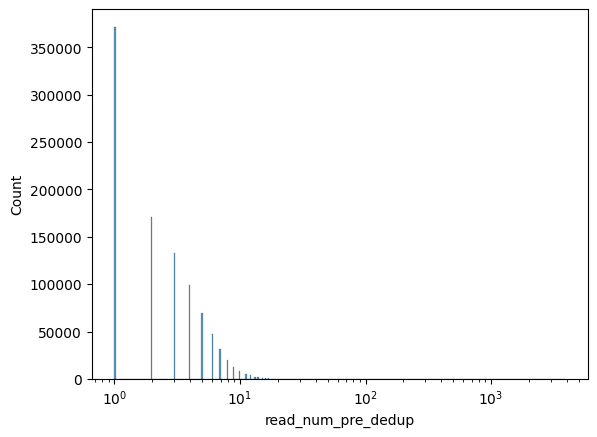

In [12]:
sns.histplot(res, x='read_num_pre_dedup', log_scale=True)

In [13]:
res.sort_values(by='read_num_post_dedup', ascending=False)

,umi,read_num_pre_dedup,read_num_post_dedup
14683,b'GAGGACGGAGTT',667,11841.0
253,b'AGCTCAGGACTG',3906,7682.0
26304,b'AATACATAGAAC',19,520.0
15788,b'GCTCCTCCAGCT',220,511.0
3917,b'GAGGATGGAACT',39,326.0
...,...,...,...
984316,b'GAGGGTGGAGCG',1,NaN
984319,b'GACGCCAATAGA',1,NaN
984320,b'AATTTACTGTTA',1,NaN
984321,b'GTTTCAGTCTCG',1,NaN


In [14]:
res.sort_values(by='read_num_pre_dedup', ascending=False)

,umi,read_num_pre_dedup,read_num_post_dedup
253,b'AGCTCAGGACTG',3906,7682.0
996,b'AACGCCGGACTG',1753,11.0
14683,b'GAGGACGGAGTT',667,11841.0
5776,b'AGCTCCGGACTG',431,14.0
3128,b'GAGAACGGAGTT',332,8.0
...,...,...,...
665857,b'TCATATTTCATA',1,NaN
665856,b'AAAAGAAGCAAG',1,2.0
665853,b'GGGTGATGGTCT',1,NaN
665852,b'CGTGATTACGAT',1,NaN


In [15]:
res.groupby(by='read_num_post_dedup').count()

,umi,read_num_pre_dedup
read_num_post_dedup,,
1.0,281988,281988
2.0,152197,152197
3.0,119610,119610
4.0,91227,91227
5.0,66572,66572
...,...,...
326.0,1,1
511.0,1,1
520.0,1,1


<Axes: xlabel='read_num_post_dedup', ylabel='Count'>

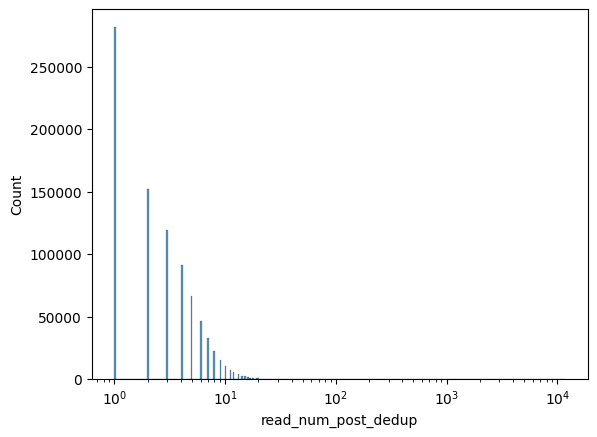

In [16]:
sns.histplot(res, x='read_num_post_dedup', log_scale=True)

In [17]:
res[res.read_num_pre_dedup > 1000]

,umi,read_num_pre_dedup,read_num_post_dedup
253,b'AGCTCAGGACTG',3906,7682.0
996,b'AACGCCGGACTG',1753,11.0


<Axes: xlabel='read_num_post_dedup', ylabel='Count'>

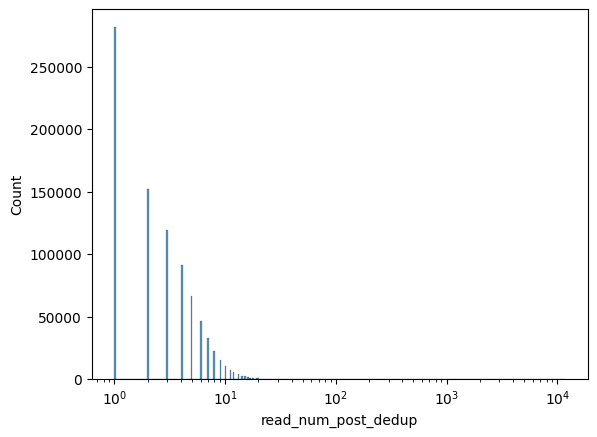

In [18]:
sns.histplot(res, x='read_num_post_dedup', log_scale=True)

In [19]:
import logomaker
def plot_logo(clonotypes, ax):
    mat_df = logomaker.alignment_to_matrix(clonotypes)
    logomaker.Logo(mat_df, color_scheme='skylign_protein', ax=ax)

(-0.475, 11.475, 0.0, 2988758.0)

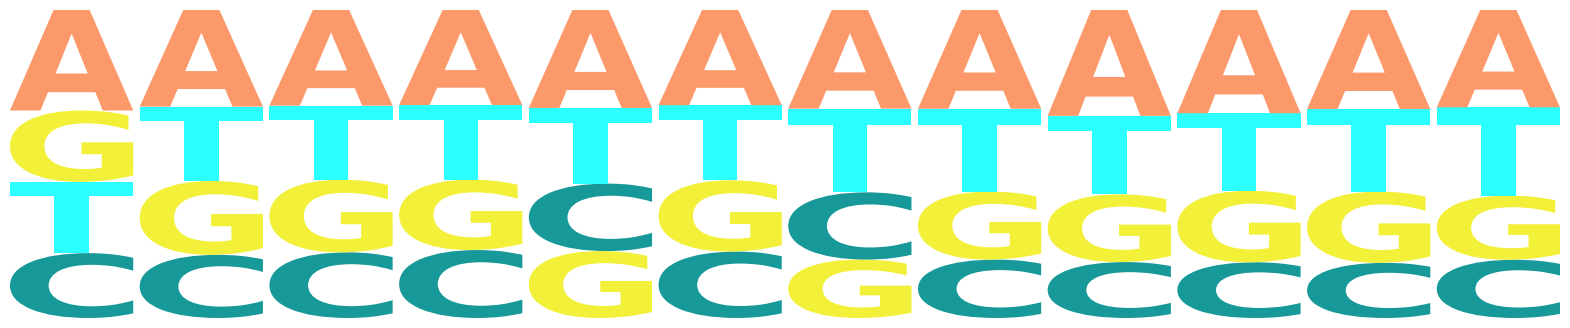

In [20]:
fig, ax = plt.subplots(figsize=(20, 4))
plot_logo([x[:12].decode('ascii') for x in sequences], 
         ax=ax)
plt.axis('off')

## reading initial data

In [23]:
'read_cluster_id', 'read_node_id', 'read_id', 'read_f_name', 'read_f_seq', 'read_f_qual', 'read_r_name', 'read_r_seq', 'read_r_qual'

('read_cluster_id',
 'read_node_id',
 'read_id',
 'read_f_name',
 'read_f_seq',
 'read_f_qual',
 'read_r_name',
 'read_r_seq',
 'read_r_qual')

In [24]:
def read_fastq_gz(fastq_file):
    sequences = []
    with gzip.open(fastq_file) as f:
        while header := f.readline().strip().decode("utf-8"):  # read header string
            if not header:
                break
            sequence = f.readline()
            _, _ = f.readline(), f.readline()
            sequences.append(sequence)
    return sequences

In [25]:
data = read_fastq_gz('../data/ERR7425614_2.fastq.gz')

In [26]:
len(data)

3313035

In [27]:
adapters = [x[:50].decode('ascii').strip() for x in data]

In [31]:
res = {}
for i in range(50):
    res[i] = pd.Series([x[i] for x in adapters]).value_counts(normalize=True)

In [32]:
pd.DataFrame(res).T

,A,C,G,N,T
0,0.001546,0.005791,0.001384,0.001605,0.989674
1,0.001863,0.009232,0.984337,0.001870,0.002699
2,0.001116,0.002355,0.990475,0.001812,0.004241
3,0.001667,0.005858,0.002557,0.001625,0.988294
4,0.985645,0.002654,0.000807,0.001721,0.009173
5,0.002030,0.007203,0.000707,0.002112,0.987948
6,0.002223,0.988154,0.000630,0.002124,0.006868
7,0.988148,0.004140,0.003517,0.002254,0.001941
8,0.989004,0.003717,0.003568,0.002171,0.001541
9,0.003248,0.987337,0.002876,0.002014,0.004525


(-0.475, 49.475, 0.0, 3313035.0)

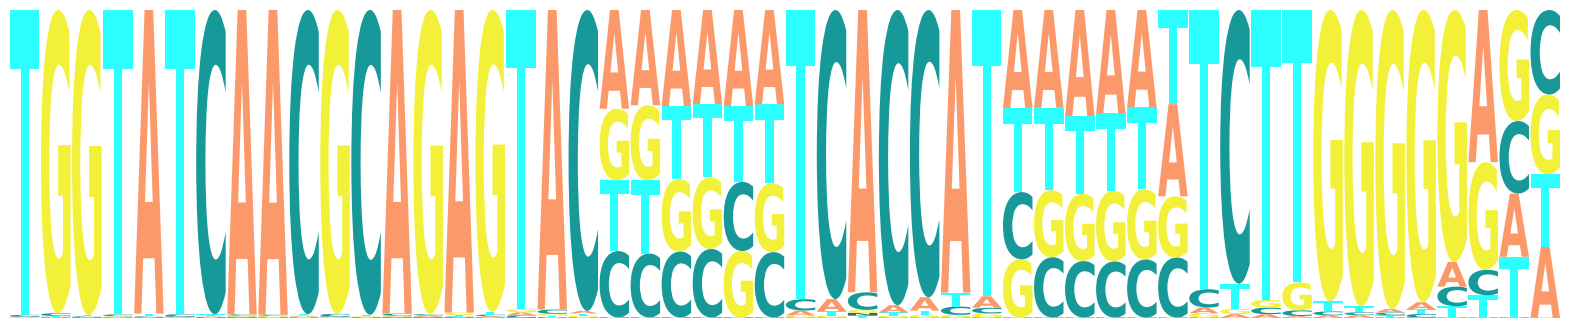

In [33]:
fig, ax = plt.subplots(figsize=(20, 4))
plot_logo(adapters, ax=ax)
plt.axis('off')